# 1: Import Libraries

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.optimizers import Adam

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# Set GPU growth to prevent memory issues
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

print("TensorFlow Version:", tf.__version__)

TensorFlow Version: 2.17.1


# 2: Load & Preprocess the Dataset

In [2]:
# Dataset path in Kaggle environment
DATASET_PATH = "/kaggle/input/scene/"

# Load images and preprocess them
IMG_SIZE = 64  # Resize all images to 64x64
BATCH_SIZE = 128
LATENT_DIM = 100  # Size of random noise vector

def load_images(dataset_path, img_size):
    images = []
    for filename in os.listdir(dataset_path):
        img_path = os.path.join(dataset_path, filename)
        try:
            img = load_img(img_path, target_size=(img_size, img_size))
            img = img_to_array(img) / 255.0  # Normalize to [0,1]
            images.append(img)
        except:
            continue
    return np.array(images)

# Load dataset
images = load_images(DATASET_PATH, IMG_SIZE)
print(f"Loaded {len(images)} images.")

# Create TensorFlow dataset for training
dataset = tf.data.Dataset.from_tensor_slices(images).shuffle(1000).batch(BATCH_SIZE)

Loaded 4319 images.


# 3: Define the Generator

In [3]:
def build_generator():
    model = tf.keras.Sequential([
        layers.Dense(8 * 8 * 256, use_bias=False, input_shape=(LATENT_DIM,)),
        layers.BatchNormalization(),
        layers.LeakyReLU(),
        layers.Reshape((8, 8, 256)),

        layers.Conv2DTranspose(128, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(64, (5, 5), strides=(2, 2), padding='same', use_bias=False),
        layers.BatchNormalization(),
        layers.LeakyReLU(),

        layers.Conv2DTranspose(3, (5, 5), strides=(2, 2), padding='same', activation='tanh')
    ])
    return model

# Initialize Generator
generator = build_generator()
generator.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 16384)               │       1,638,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 16384)               │          65,536 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 16384)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 8, 8, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 16, 16, 128)         │         819,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 16, 16, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 32, 32, 64)          │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 32, 32, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 64, 64, 3)           │           4,803 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,733,507 (10.43 MB)

 Trainable params: 2,700,355 (10.30 MB)

 Non-trainable params: 33,152 (129.50 KB)

# 4: Define the Discriminator

In [4]:
def build_discriminator():
    model = tf.keras.Sequential([
        layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 3)),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'),
        layers.LeakyReLU(alpha=0.2),
        layers.Dropout(0.3),

        layers.Flatten(),
        layers.Dense(1, activation='sigmoid')
    ])
    return model

# Initialize Discriminator
discriminator = build_discriminator()
discriminator.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 32, 32, 64)          │           4,864 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 32, 32, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 16, 16, 128)         │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 16, 16, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │          32,769 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 242,561 (947.50 KB)

 Trainable params: 242,561 (947.50 KB)

 Non-trainable params: 0 (0.00 B)

# 5: Define Loss & Optimizers

In [5]:
# Loss function
cross_entropy = tf.keras.losses.BinaryCrossentropy()

# Discriminator loss
def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    return real_loss + fake_loss

# Generator loss
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output), fake_output)

# Optimizers
generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

# 6: Define the Training Loop

Epoch 0: Generator Loss: 1.5750, Discriminator Loss: 0.3175


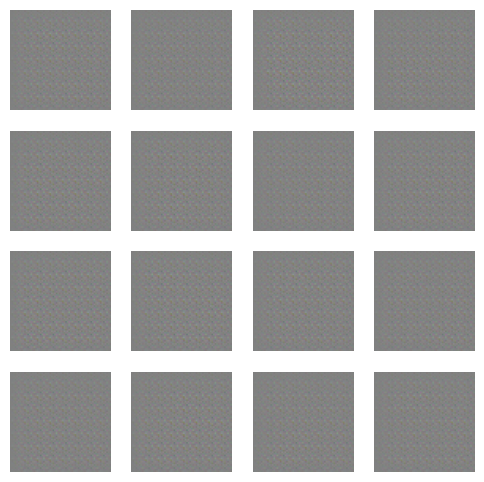

Epoch 500: Generator Loss: 2.3333, Discriminator Loss: 0.6136


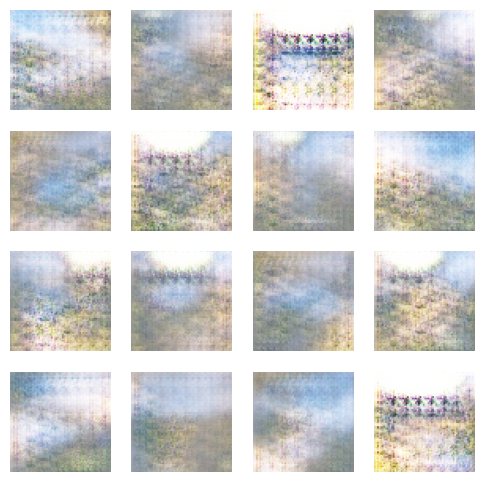

Epoch 1000: Generator Loss: 2.1560, Discriminator Loss: 0.7606


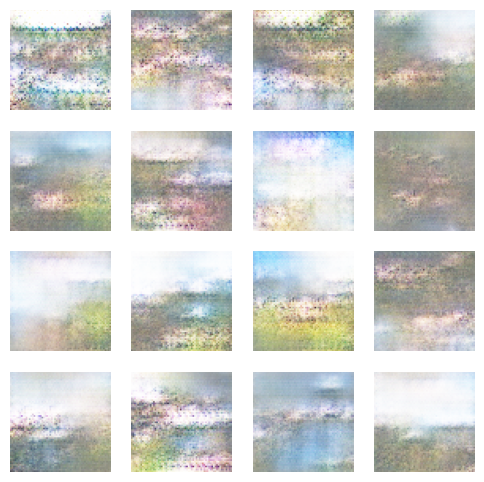

Epoch 1500: Generator Loss: 1.3855, Discriminator Loss: 0.7281


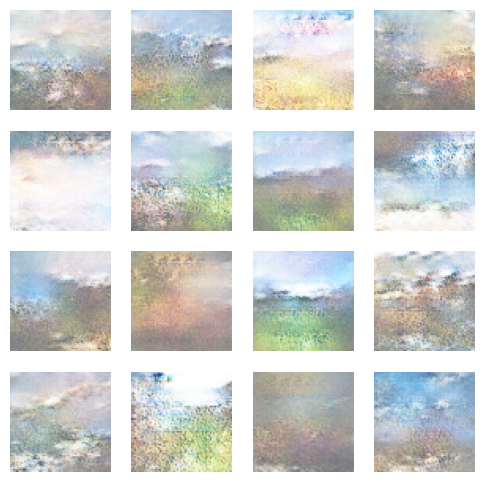

Epoch 2000: Generator Loss: 2.1519, Discriminator Loss: 0.5776


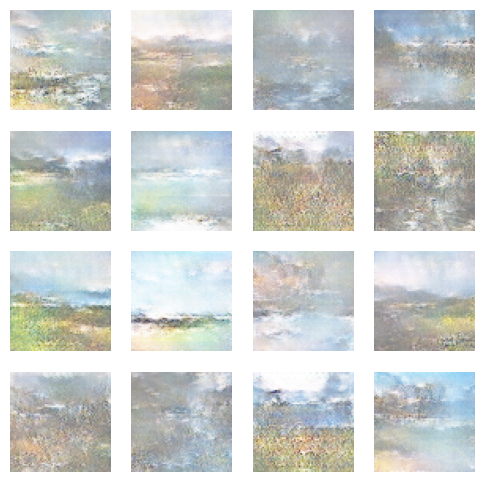

Epoch 2500: Generator Loss: 1.7901, Discriminator Loss: 0.7834


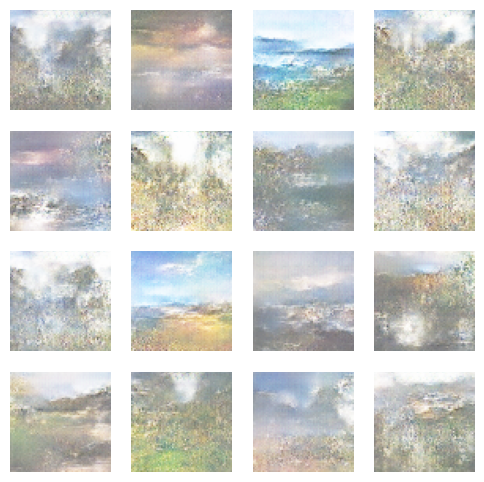

Epoch 3000: Generator Loss: 2.0217, Discriminator Loss: 0.7084


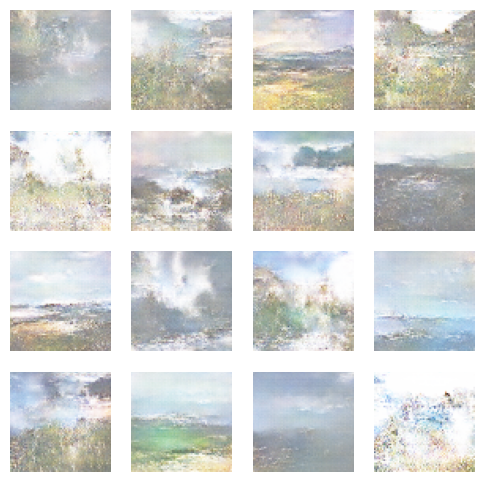

Epoch 3500: Generator Loss: 1.0884, Discriminator Loss: 0.9970


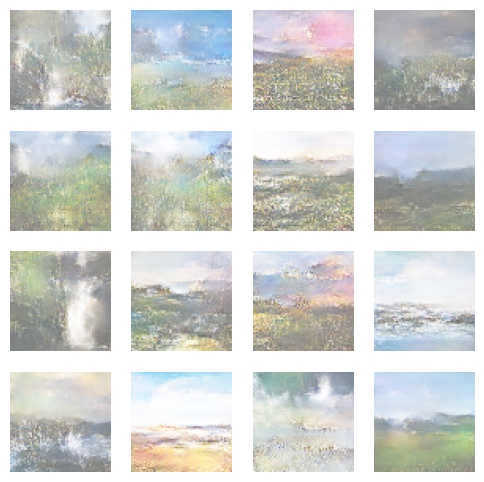

Epoch 4000: Generator Loss: 1.3725, Discriminator Loss: 1.0144


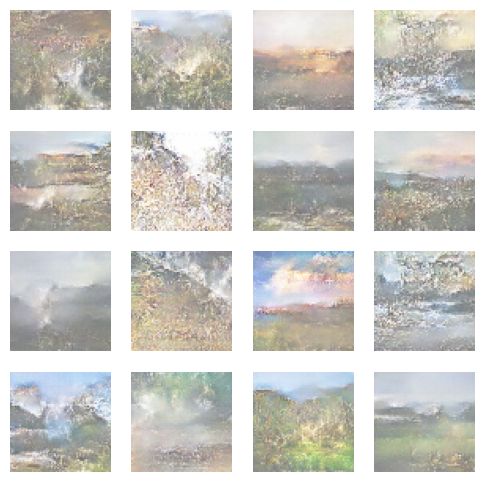

Epoch 4500: Generator Loss: 1.7155, Discriminator Loss: 0.7856


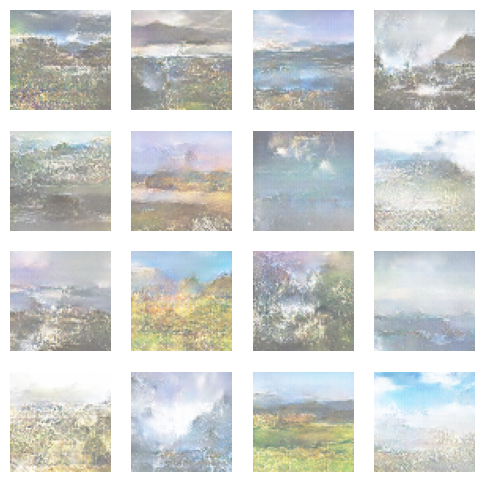

In [6]:
# Training function
EPOCHS = 5000  # Adjust as needed
SAVE_INTERVAL = 500

@tf.function
def train_step(real_images):
    noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)
        
        real_output = discriminator(real_images, training=True)
        fake_output = discriminator(generated_images, training=True)
        
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss

# Training Loop
def train(dataset, epochs):
    for epoch in range(epochs):
        for image_batch in dataset:
            g_loss, d_loss = train_step(image_batch)

        if epoch % SAVE_INTERVAL == 0:
            print(f"Epoch {epoch}: Generator Loss: {g_loss:.4f}, Discriminator Loss: {d_loss:.4f}")
            generate_and_save_images(generator, epoch)

# Generate & save images
def generate_and_save_images(model, epoch):
    noise = tf.random.normal([16, LATENT_DIM])
    generated_images = model(noise, training=False)

    fig, axs = plt.subplots(4, 4, figsize=(6, 6))
    for i in range(16):
        ax = axs[i // 4, i % 4]
        ax.imshow((generated_images[i] + 1) / 2)  # Rescale to [0,1]
        ax.axis('off')

    plt.savefig(f'generated_epoch_{epoch}.png')
    plt.show()

# Start training
train(dataset, EPOCHS)

# 7: Generate Landscapes After Training

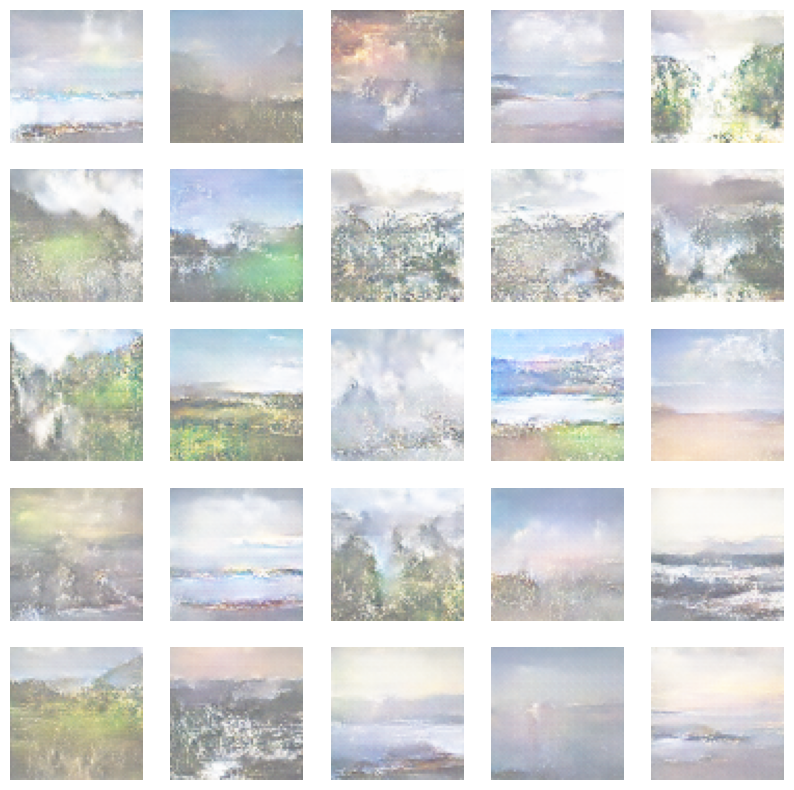

In [7]:
# Generate landscapes from random noise after training
def generate_final_images():
    noise = tf.random.normal([25, LATENT_DIM])
    generated_images = generator(noise, training=False)

    fig, axs = plt.subplots(5, 5, figsize=(10, 10))
    for i in range(25):
        ax = axs[i // 5, i % 5]
        ax.imshow((generated_images[i] + 1) / 2)  # Rescale to [0,1]
        ax.axis('off')

    plt.show()

# Generate images
generate_final_images()